# 2nd-order elastic with a diagonal boundary

This notebook considers an even more fancy boundary.

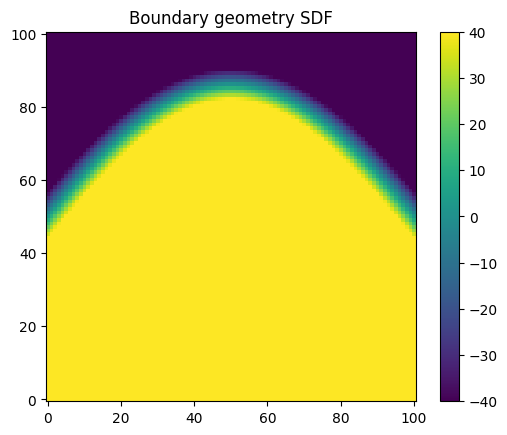

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
from schism import BoundaryGeometry
bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv
import numpy as np
import matplotlib.pyplot as plt

s_o = 2

ux = dv.TimeFunction(name='ux', grid=grid, space_order=s_o, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=s_o, time_order=2)

# Material parameters
rho = 1.
mu = 0.25
lam = 0.5

# Shorthand
b = 1./rho

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

bc_list = [dv.Eq(nx*(lam+2*mu)*ux.dx + nx*lam*uy.dy
                 + ny*mu*ux.dy + ny*mu*uy.dx, 0),
           dv.Eq(nx*mu*ux.dy + nx*mu*uy.dx
                 + ny*(lam+2*mu)*uy.dy + ny*lam*ux.dx, 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

derivs = (ux.dx2, ux.dy2, ux.dxdy, uy.dx2, uy.dy2, uy.dxdy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(ux(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [6]:
from examples.seismic import TimeAxis, RickerSource

c = np.sqrt(b*(lam+2*mu))

t0 = 0.  # Simulation starts a t=0
tn = 850.  # Simulation last 0.5 seconds (500 ms)
dt = 0.5*grid.spacing[0]/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 600.

In [7]:
# Stability check
alpha = np.sqrt((lam+2*mu)/rho)
beta = np.sqrt(mu/rho)
dx = np.amin(grid.spacing)


print(dt)
print("Must be smaller than")
print(dx/np.sqrt(alpha**2 + beta**2))

5.0
Must be smaller than
8.94427190999916


In [8]:
rhs_ux = b*(lam+2*mu)*ux.dx2 + b*mu*ux.dy2 + b*(lam+mu)*uy.dxdy
rhs_uy = b*(lam+2*mu)*uy.dy2 + b*mu*uy.dx2 + b*(lam+mu)*ux.dxdy

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux.subs(subs))

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy.subs(subs))

In [9]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)
src_uy = src.inject(field=uy.forward, expr=-src*dt**2)

In [10]:
op = dv.Operator([eq_ux, eq_uy] + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.14 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.13337100000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=3.699999999999999e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

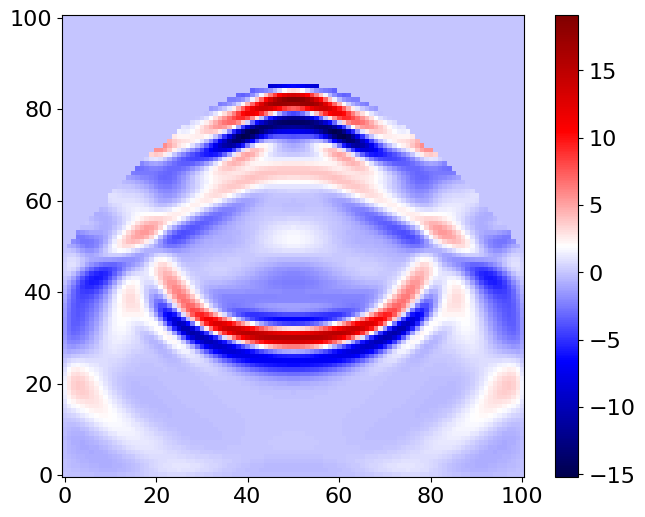

In [11]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

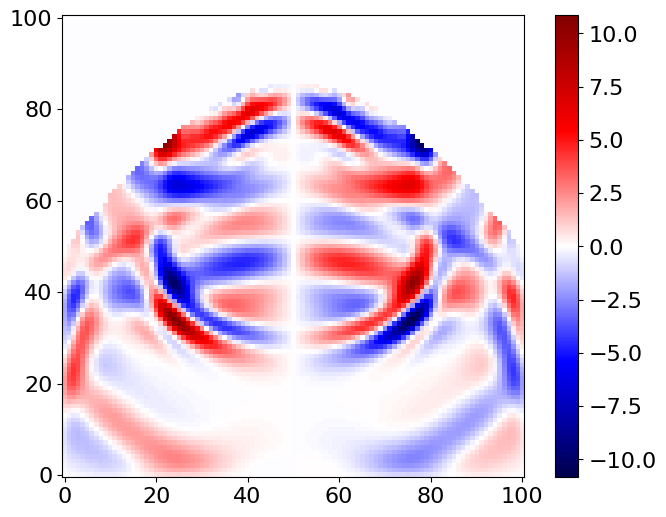

In [12]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [13]:
assert np.isclose(np.linalg.norm(ux.data), 511.65524)
assert np.isclose(np.linalg.norm(uy.data), 340.18506)